# Introduction

In this tutorial, we will learn about different environments, then implement dynamic programming (model-based) algorithms and study their performance.

# Notebook setup

## Instructions

- Import numpy, scipy and matplotlib
- Configure inline plots

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
%autosave 100

Autosaving every 100 seconds


# Tutorial

In order to learn about RL algorithms, we will explore different worlds (also called environments), which are listed below. For more details about each world, please look into their implementation in module RL_worlds.

## N-armed bandit task

In an N-armed bandit task, there is only a single state. Our implementation is a 4-armed bandit, which means there are 4 available actions, and each one returns a different reward.

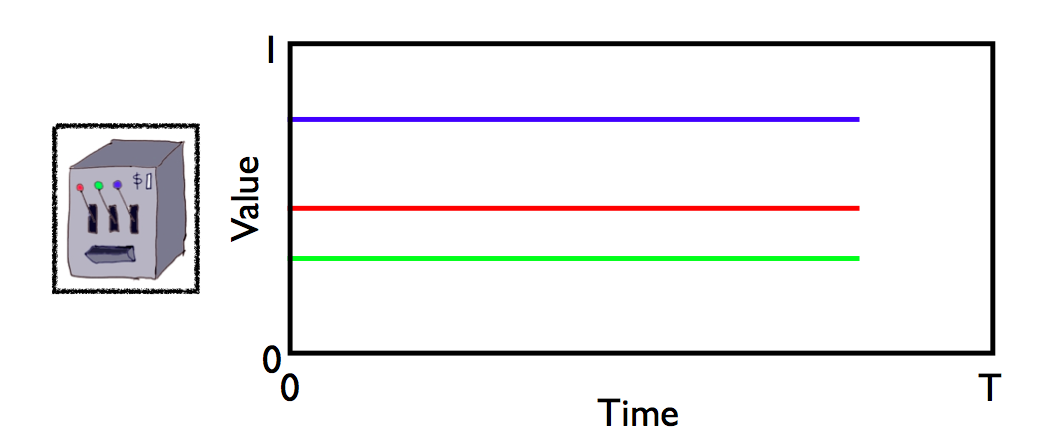

In [2]:
from IPython.display import Image
Image(filename="fig/4ArmedBandit.png", width=600, height=225)

## Cheese world

In this one-dimensional grid there are 4 states and 2 possible actions: left and right. Arriving at the goal state gives you a reward of 1. Moving left from the start state (state 1 in the figure) stays in the same place, and moving anywhere from the goal state (state 4 in the figure) ends the episode.

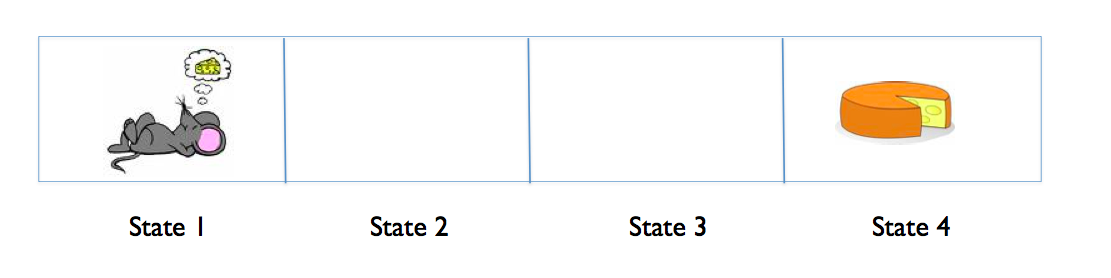

In [3]:
from IPython.display import Image
Image(filename="fig/CheeseWorld.png", width=600, height=225)

## Cliff world

In this 4x10 grid there are 40 states and 4 possible actions: right, up, left and down. Falling into the cliff incurs a negative reward of -100 and ends the episode; moving into any other state incurs a reward of -1; moving into the world borders stays in the same place; moving anywhere from the goal state (state G in the figure) ends the episode.

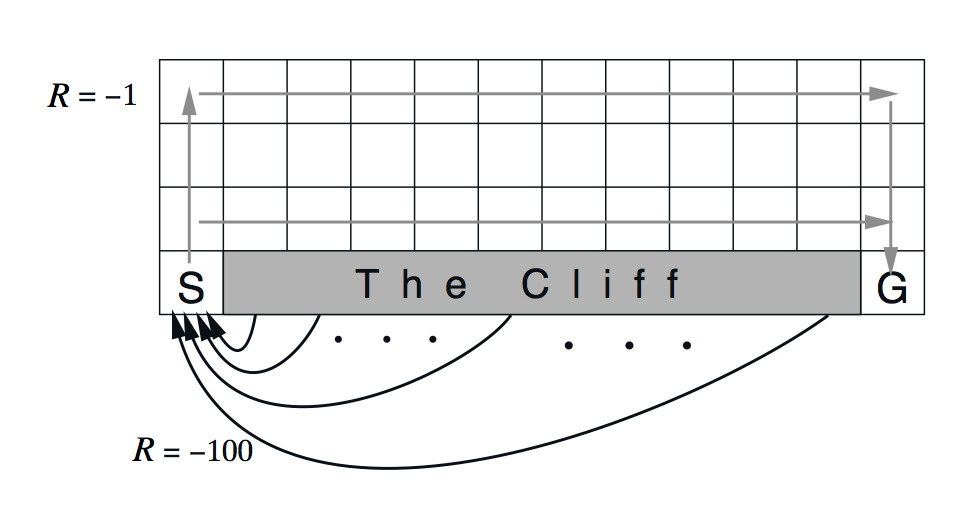

In [4]:
from IPython.display import Image
Image(filename="fig/CliffWorld.png", width=600, height=225)

## Quentin's world

In this 10x10 grid there are 100 states and 4 possible actions: right, up, left and down. The start state is in green in the figure; moving into one of the red states incurs a reward of -1; moving into the world borders stays in the same place; moving into the goal state (yellow square in the upper right corner) gives you a reward of 1; and moving anywhere from the goal state ends the episode.

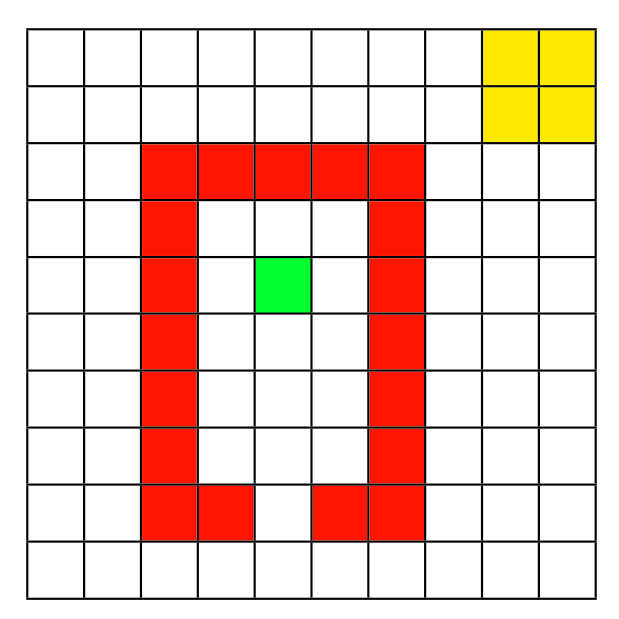

In [5]:
from IPython.display import Image
Image(filename="fig/QuentinsWorld.png", width=300, height=300)

## Multi-room windy gridworld with cliffs

In this 12x14 grid there are 168 states and 4 possible actions: right, up, left and down. The start state is marked with an S in the figure, and there are 2 goals states marked with a G. Each goal state is inside a room (the room walls are marked with darker lines). Moving into a goal states gives you a reward of 100. Moving into a wall or outside the world borders stays in the same place. The two rooms are windy, which means the resultant next states inside the rooms are shifted; the wind direction is indicated by a blue arrow, and the wind strength (size of the shift) in each column is indicated by a number between 0 and 2. There are also two cliffs marked in gray; falling into a cliff incurs a reward of -100 and ends the episode. 

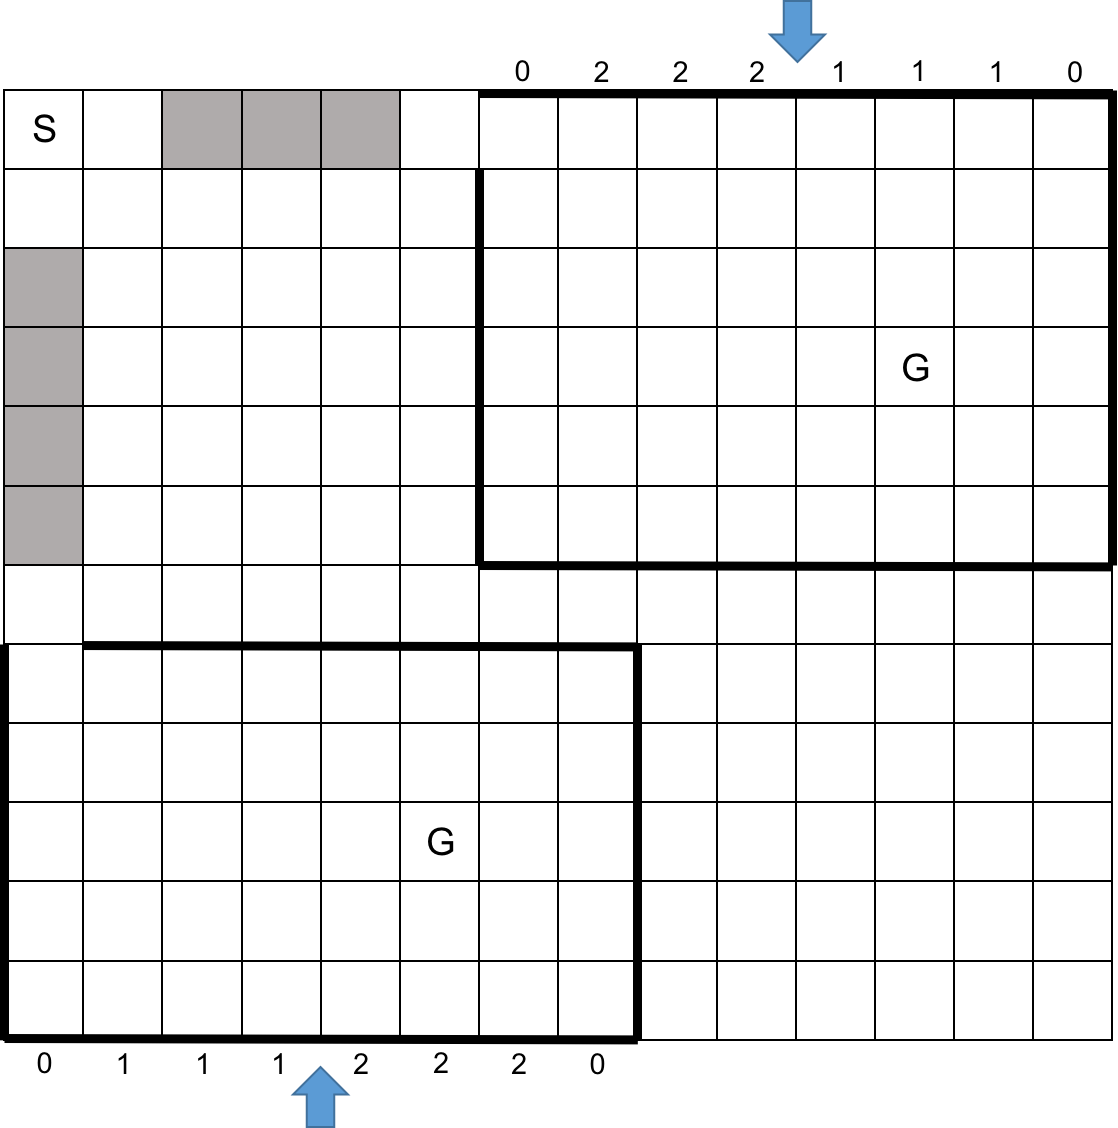

In [6]:
from IPython.display import Image
Image(filename="fig/gridworld.png", width=451.2, height=447.2)

## Helper functions

Please familiarize yourself with the code below, as it will help your write your own code to solve the exercises.

In [7]:
# Import definitions of the environments.
import RL_worlds as worlds

# Import helper functions for plotting.
from plot_util import *

In [8]:
def default_params(environment):
    """
    Define the default parameters.
    Args:
        environment: an object corresponding to the environment.
    Returns:
        a dictionary containing the default parameters, where the keys
            are strings (parameter names).
    """
    params = dict()
    params['environment'] = environment
    
    params['alpha'] = 0.1  # learning rate    
    params['beta'] = 10  # inverse temperature    
    params['policy'] = 'epsilon_greedy'
    params['epsilon'] = 0.05  # epsilon-greedy policy    
    params['learning_rule'] = 'q_learning'
    params['epsilon_decay'] = 0.9
    
    if environment.name == 'windy_cliff_grid':
        params['gamma'] = 0.8  # temporal discount factor
    elif environment.name == 'n_armed_bandit':
        params['gamma'] = 0.9  # temporal discount factor
    elif environment.name == 'cliff_world':
        params['gamma'] = 1.0  # no discounting
    elif environment.name == 'cheese_world':
        params['gamma'] = 1.0  # no discounting
    elif environment.name == 'quentins_world':
        params['gamma'] = 0.9  # temporal discount factor

    return params

## Exercise 1: Policy Evaluation

1. Write the policy evaluation algorithm.

Tip: the function should take the policy to be evaluated, the default parameters and a threshold for the stopping criterium as input and return the value function.

In [9]:

def policy_eval(policy, params, thr):
    
    outcomes = params['environment'].get_all_outcomes()
    n_states = params['environment'].n_states
    n_actions = params['environment'].n_actions
    
    gamma = params['gamma']
    V = np.zeros(n_states)
    control = True
    while control:              
        V1 = np.zeros(n_states)
        
        for s in range(n_states):
            for a in range(n_actions):
                sp = outcomes[s,a][0][1]      
                r = outcomes[s,a][0][2]
                
                if sp == None:
                    V1[s] += policy[s,a]*r
                else:
                    V1[s] += policy[s,a]*(r + gamma*V[sp])
                
        if np.max(abs(V-V1)) < thr:
                    control = False
        V = V1
        
    
    return V1
    

    

In [10]:
environment = worlds.cheese_world()
params = default_params(environment)
n_states = params['environment'].n_states
n_actions = params['environment'].n_actions

policy1 = np.zeros((n_states,n_actions))+1./n_actions


    
print policy1
thr = 0.00001

policy_eval(policy1, params, thr)



[[ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]]


array([ 0.99991686,  0.99993333,  0.999963  ,  0.        ])

In [11]:
policy1[0,:]

array([ 0.5,  0.5])

## Exercise 2: Policy Iteration

1. Write the policy iteration algorithm.

Tips: the function should take the default parameters and a threshold for the stopping criterium as input and return the optimal policy and the value function for the optimal policy; you should use the policy evaluation function written in Exercise 1.

In [12]:
def policy_iter(params,thr):
    
    outcomes = params['environment'].get_all_outcomes()
    n_states = params['environment'].n_states
    n_actions = params['environment'].n_actions
    
    gamma = params['gamma']
    
    
    #policy initialization
    policy = np.zeros((n_states,n_actions))+1./n_actions

    
    #pi = np.zeros(n_states,dtype = int)
    V = np.zeros(n_states)
    stable = False
    iteration = 0
    
    while stable == False:

        iteration += 1
        if iteration > 500:
            break
            
        V = policy_eval(policy, params, thr)
        stable = True 
        
        #policy = np.zeros((n_states,n_actions))
        for s in range(n_states):
            b = np.argmax(policy[s])
            
            r = np.zeros(n_actions)
            
            for a in range(n_actions):
                for (transition_prob, sp, reward) in outcomes[s,a]:
               
                    if sp == None:  
                        r[a] = reward*transition_prob
                    else:
                        r[a] = (reward + gamma*V[sp])*transition_prob
            
            best_choice = np.argmax(r)
            
           
            
            if b != best_choice:
                stable = False
                
            policy[s] = np.eye(1,n_actions,best_choice)[0]
                              
    
    return policy,V  

In [13]:
w = worlds.n_armed_bandit()
params = default_params(w)
[policy,v] = policy_iter(params,thr)


In [14]:
policy

array([[ 0.,  0.,  0.,  1.]])

In [15]:
v

array([ 1.])

## Exercise 3: Value Iteration

One drawback to policy iteration is that each of its iterations involves policy evaluation, which may be slow due to multiple sweeps through the state set. We can make this process faster by truncating the policy evaluation step of policy iteration, stopping it after just one sweep (one backup of each state). This modified algorithm is called value iteration. You can read more about it here: http://artint.info/html/ArtInt_227.html

1. Write the value iteration algorithm.

Tips: the function should take the default parameters and a threshold for the stopping criterium as input and return the policy and corresponding value function; you can write a helper function to calculate the one-step lookahead, i.e., the value for all actions in a given state using the current estimate of the value function.

In [19]:
def value_iter(params,thr):
    outcomes = params['environment'].get_all_outcomes()
    n_states = params['environment'].n_states
    n_actions = params['environment'].n_actions
    
    gamma = params['gamma']
    V = np.zeros(n_states)
    best_choice = np.zeros(n_states,dtype = int)
    
    while True:
        delta = 0
        for s in range(n_states):
            temp = V[s]
            r = np.zeros(n_actions)
            for a in range(n_actions):    
               
                
                for (transition_prob, sp, reward) in outcomes[s,a]:
                    
                    if sp == None:  
                        r[a] += reward*transition_prob
                    else:
                        r[a] += (reward + gamma*V[sp])*transition_prob
               
            V[s] = np.max(r)
        
            best_choice[s] = np.argmax(r)
            
            delta = np.maximum(delta, np.abs(V[s]-temp))
        
        if delta<thr:
            break
    
    policy = np.zeros((n_states,n_actions))
    for s in range(n_states):
        policy[s] = np.eye(1,n_actions,best_choice[s])[0]
    
    return policy, V 
    
    
    
    
    

In [17]:
w = worlds.cliff_world()
params = default_params(w)
params['gamma'] = 0.9

value_iter(params,1e-6)

(array([[ 0.,  1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 

## Exercise 4 

1. Write code that allows you to test the performance of policy iteration and value iteration for a selected world (try cliff world, Quentin's world or windy cliff grid). Use the functions provided in the plot_util module to:
    - Plot the action corresponding to the policy at each state;
    - Plot the value associated with each state.
2. Experiment with different parameter values:
    - Pick a range for the temporal discount factor $\gamma$ and look at how the results change.
3. Compare the results obtained using policy iteration to those obtained using value iteration. Do you notice any differences in their performance?

To make sure that your algorithms have been implemented correctly, compare your results to the ones shown below.

Cliff world using policy iteration and $\gamma$=0.9:

<img src="fig/tutorial1_ex4_policyimp_actions.png",height="300",width="300",align="left">
<img src="fig/tutorial1_ex4_policyimp_maxval.png",height="300",width="300">

Quentin's world using using value iteration and $\gamma$=0.9:

<img src="fig/tutorial1_ex4_valueit_actions.png",height="300",width="300",align="left">
<img src="fig/tutorial1_ex4_valueit_maxval.png",height="300",width="300">

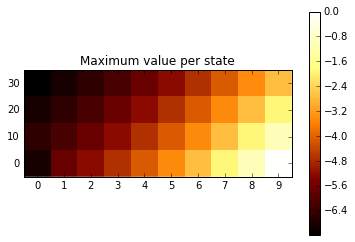

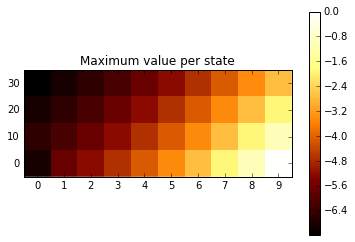

In [20]:
w = worlds.cliff_world()
params = default_params(w)
params['gamma'] = 0.9
thr = 1e-5

#[policy,value] = policy_iter(params,thr)

[policy2, Value2] = value_iter(params,1e-3)


#print Value2

#plot_quiver_max_action(w, policy2)

plot_heatmap_max_val(w,Value2)